In [2]:
import chess
import pandas as pd
from collections import defaultdict as dd
import numpy as np
import chess.engine
from tqdm.notebook import tqdm
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
engine = chess.engine.SimpleEngine.popen_uci(r"C:\Users\tonyt\Downloads\stockfish\stockfish\stockfish-windows-x86-64-avx2.exe")

In [ ]:
def clean(x):
    board = chess.Board(fen=x["FEN"])
    x["Moves"] = [chess.Move.from_uci(move) for move in x["Moves"].split()]
    board.push(x["Moves"].pop(0))
    x["FEN"] = board.fen()
    return x
dataset = pd.read_csv(r"C:\Users\tonyt\Downloads\lichess_db_puzzle\lichess_db_puzzle.csv")
dataset = dataset[dataset['NbPlays'] >= 100]
samples = dataset.apply(lambda x:clean(x), axis=1)


In [248]:
samples = pd.read_csv('ML Data.csv')

In [250]:
piece_values = {
    chess.PAWN: 1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK: 5,
    chess.QUEEN: 9, 
    chess.KING: 0
}

In [249]:
themes=set()
for theme_list in samples['Themes']:
    for word in theme_list.split():
        themes.add(word)


In [257]:
def get_material_difference(board, my_color):
    return sum(piece_values[piece.piece_type] for piece in board.piece_map().values() if piece.color == my_color) - sum(piece_values[piece.piece_type] for piece in board.piece_map().values() if piece.color != my_color)

# def is_symmetric(board1, board2):
#     # check if two boards are equal by comparing the pieces on each square
#     for square in chess.SQUARES:
#         if board1.piece_at(square) != board2.piece_at(square):
#             return False
#     return True

X={"material_sacrifice": [], "puzzle_length": [], "avg_num_captured": [], "avg_num_being_captured": [], "material_difference": [], "avg_num_bad_checks": [], "avg_num_bad_captures": [], "avg_legal_moves": []}
y=samples["Rating"]
for _, puzzle in tqdm(samples.iterrows()):
    board = chess.Board(puzzle["FEN"])
    my_color = board.turn
    captured = 0
    being_captured = 0
    total_sacrifice = 0
    exchange_material_loss = 0
    bad_checks = 0
    bad_captures = 0
    legal_moves = 0
    for move in puzzle["Moves"]:
        if board.is_capture(move):
            captured_piece = board.piece_at(move.to_square)
            #empassant
            if captured_piece == None:
                captured_piece = chess.Piece(chess.PAWN, not board.turn)
            if captured_piece.color == my_color:
                exchange_material_loss += piece_values[captured_piece.piece_type]
                being_captured += 1
            else:
                exchange_material_loss -= piece_values[captured_piece.piece_type]
                captured += 1
        elif exchange_material_loss:
            # the capture series end and someone lost material
            if exchange_material_loss > 0:
                #if I lost more materials for win/advantage
                total_sacrifice += exchange_material_loss

            exchange_material_loss = 0

        # check tempting bad moves
        if board.turn == my_color:
            moves = list(board.legal_moves)
            legal_moves += len(moves)
            moves.remove(move)
            for bad_move in moves:
                if board.is_capture(bad_move):
                    bad_captures += 1
                if board.gives_check(bad_move):
                    bad_checks += 1
                    
        
        #explore next move
        board.push(move)

    if exchange_material_loss > 0:
        total_sacrifice += exchange_material_loss
        
    X["material_sacrifice"].append(total_sacrifice)
    X["puzzle_length"].append(len(puzzle["Moves"]))
    X["avg_num_captured"].append(captured / len(puzzle["Moves"]))
    X["avg_num_being_captured"].append(being_captured / len(puzzle["Moves"]))
    X["material_difference"].append(get_material_difference(board, my_color))
    X["avg_num_bad_checks"].append(bad_checks / len(puzzle["Moves"]))
    X["avg_num_bad_captures"].append(bad_captures / len(puzzle["Moves"]))
    X["avg_legal_moves"].append(legal_moves / len(puzzle["Moves"]))
for theme in themes:
    X[theme] = samples["Themes"].apply(lambda x: theme in x).astype(int)

0it [00:00, ?it/s]

In [261]:
#change branching factor
for _, puzzle in tqdm(samples.iterrows()):
    board = chess.Board(puzzle["FEN"])
    my_color = board.turn
    legal_moves = 0
    for move in puzzle["Moves"]:

        # check tempting bad moves
        if board.turn == my_color:
            moves = list(board.legal_moves)
            legal_moves += len(moves)**0.8
                    
        
        #explore next move
        board.push(move)
    X["avg_branching_factor"].append(legal_moves / len(puzzle["Moves"]))

0it [00:00, ?it/s]

In [3]:
#load features
df = pd.read_csv("features.csv")
dataset = pd.read_csv(r"C:\Users\tonyt\Downloads\lichess_db_puzzle\lichess_db_puzzle.csv")
dataset = dataset[dataset['NbPlays'] >= 100]
y = dataset["Rating"].to_numpy()

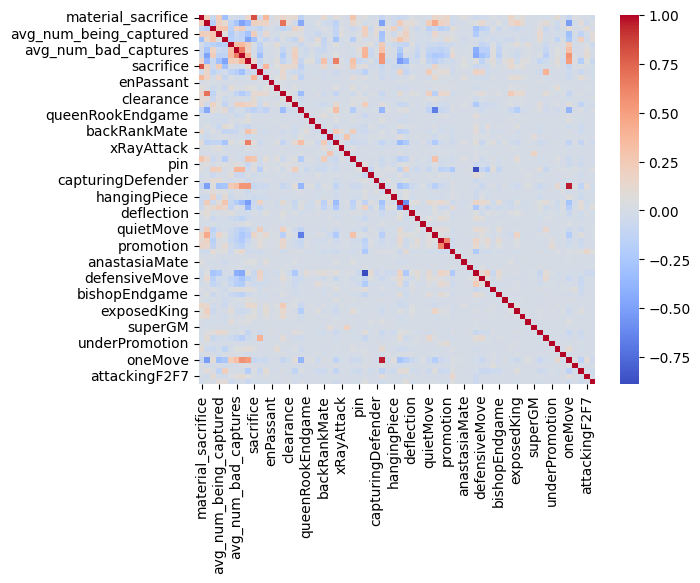

               Feature 1               Feature 2  Correlation
1     material_sacrifice           puzzle_length     0.223987
2     material_sacrifice        avg_num_captured    -0.088125
3     material_sacrifice  avg_num_being_captured     0.222852
4     material_sacrifice     material_difference    -0.310498
5     material_sacrifice      avg_num_bad_checks    -0.012806
...                  ...                     ...          ...
4618        trappedPiece            interference    -0.004274
4619        trappedPiece                 oneMove    -0.041378
4620        trappedPiece               bodenMate    -0.002741
4621        trappedPiece                    fork    -0.041874
4622        trappedPiece           attackingF2F7    -0.006848

[4556 rows x 3 columns]


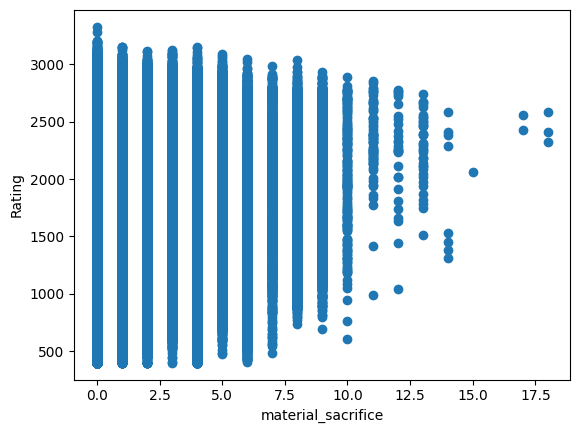

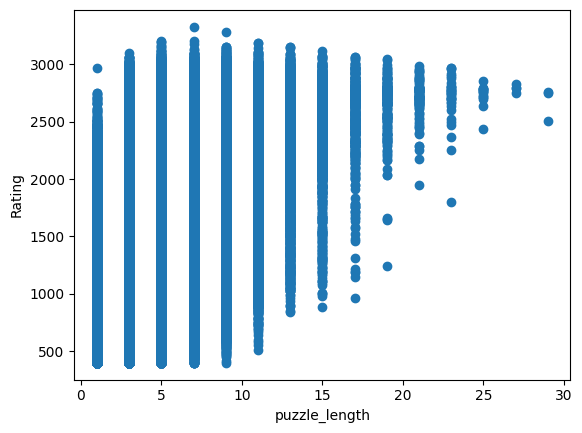

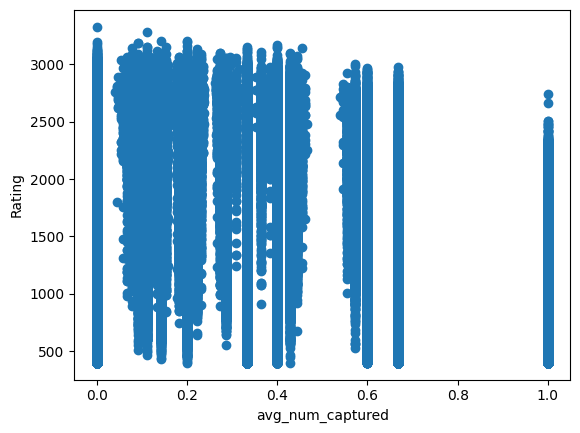

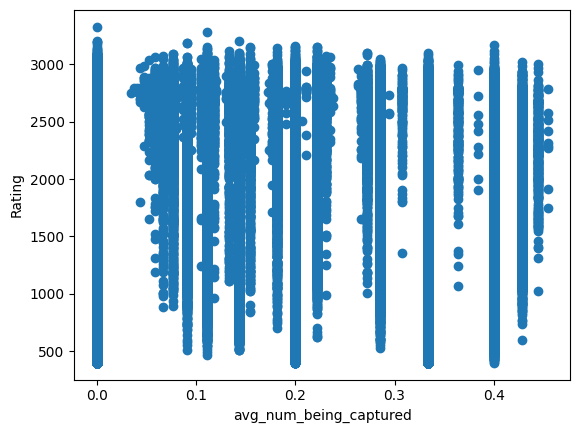

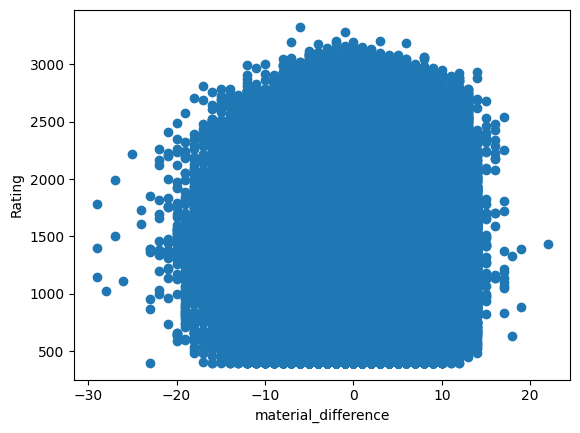

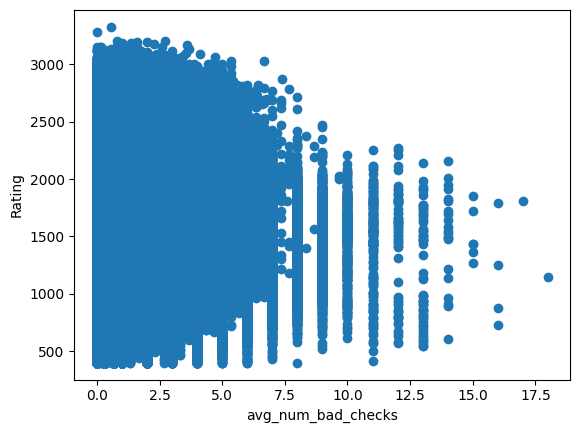

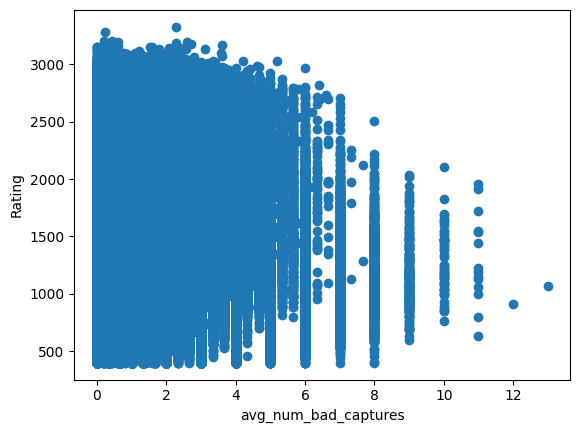

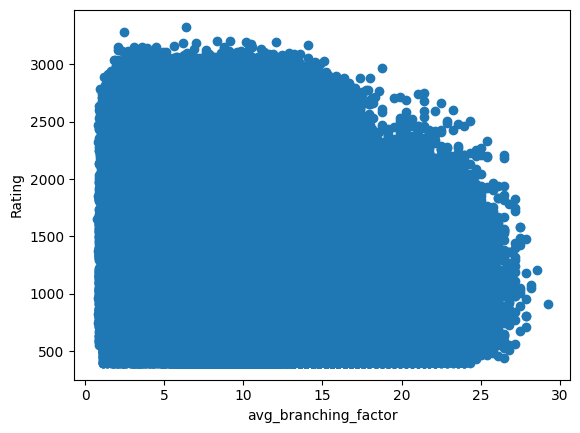

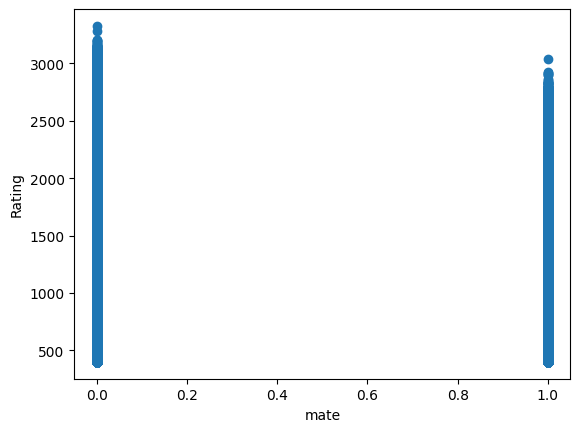

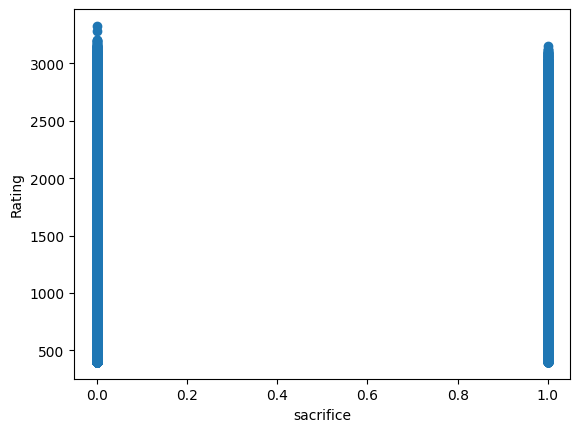

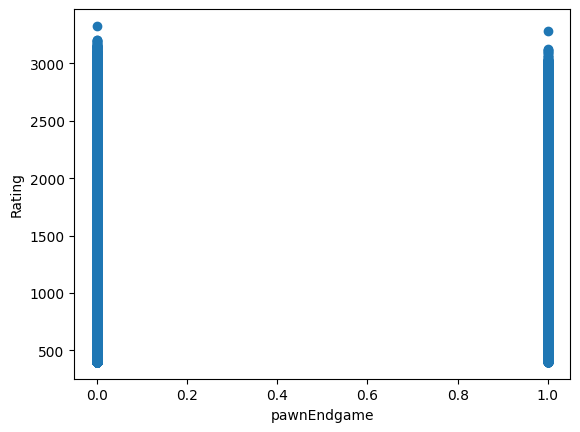

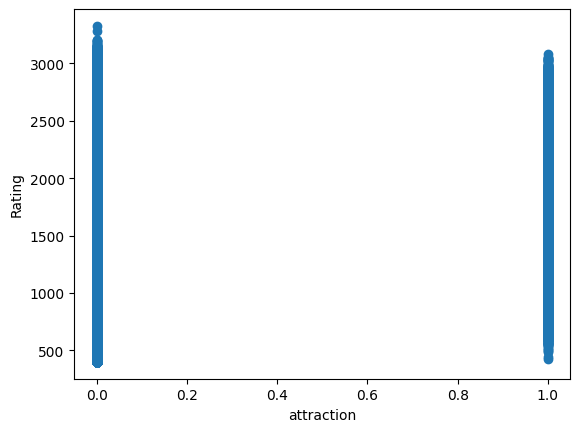

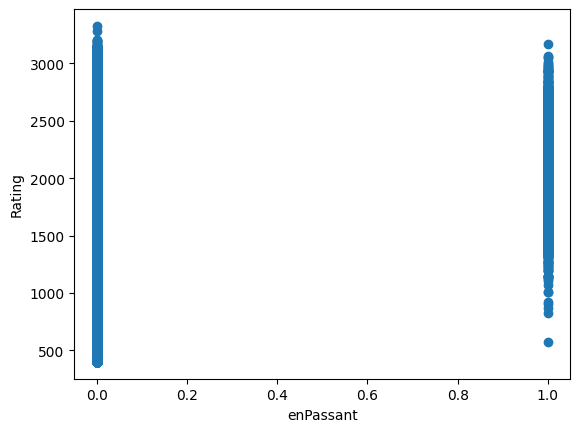

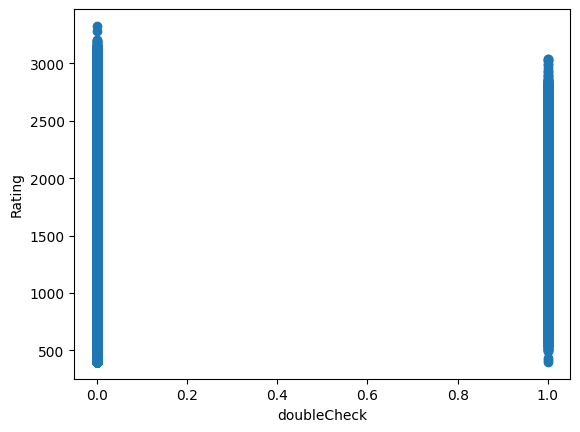

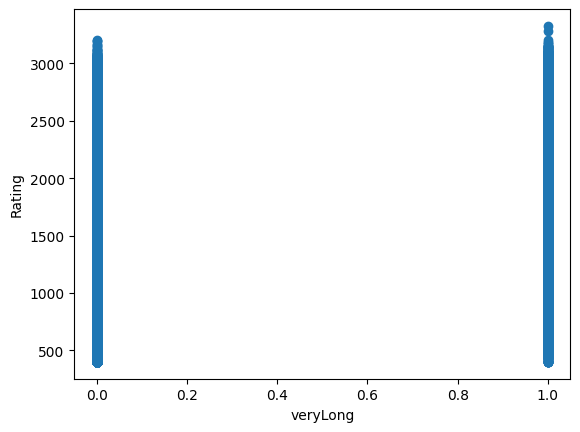

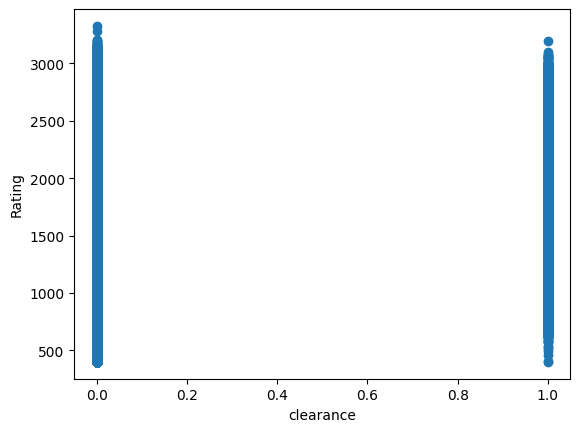

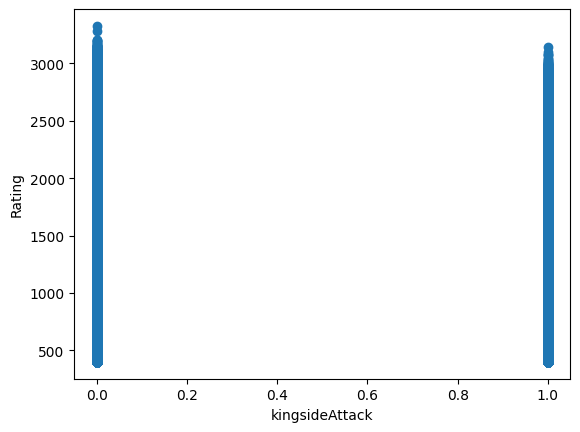

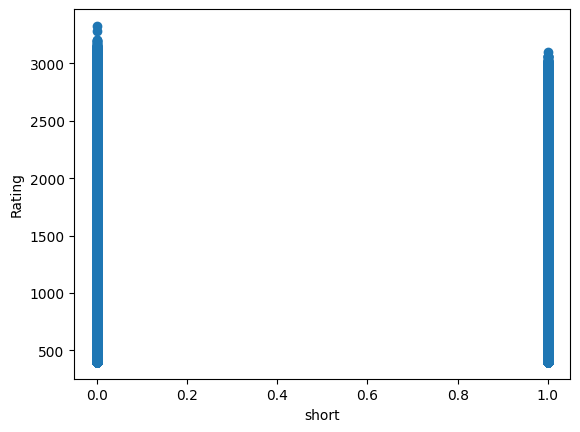

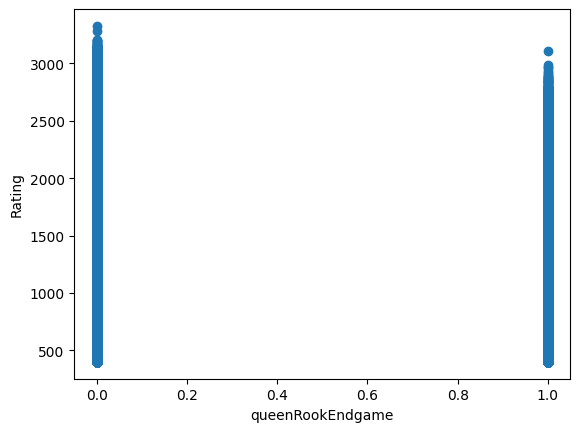

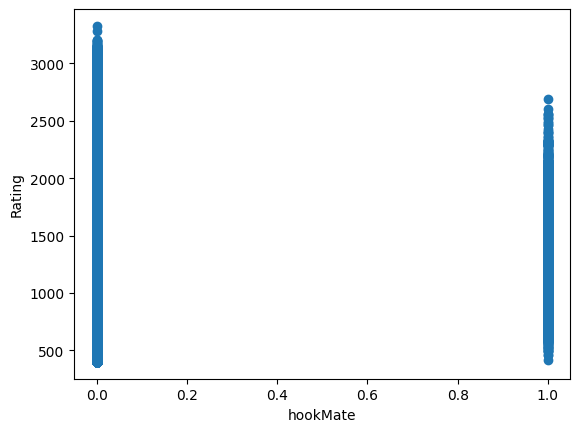

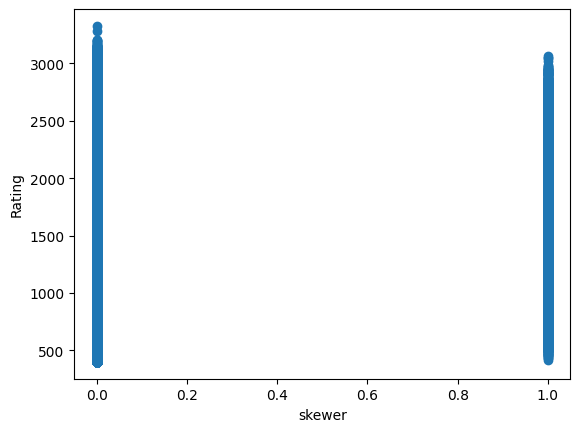

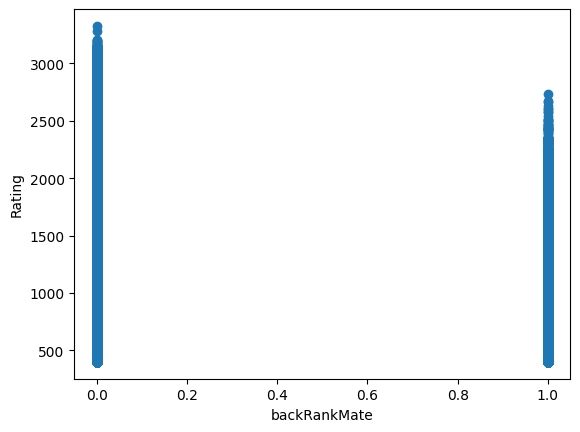

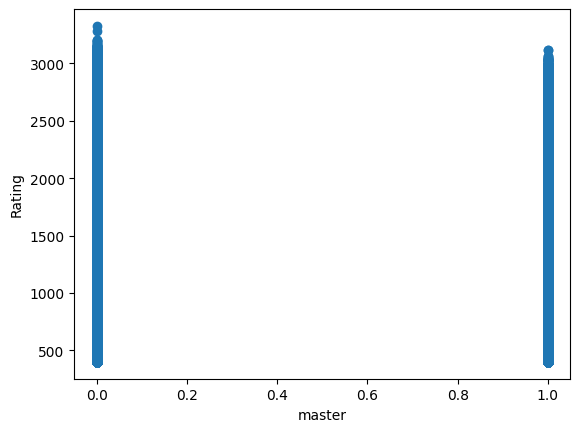

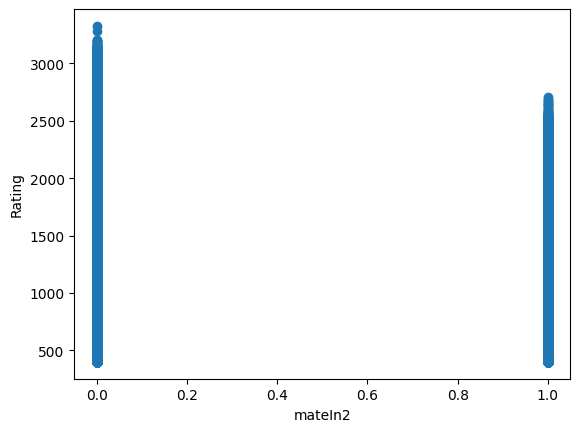

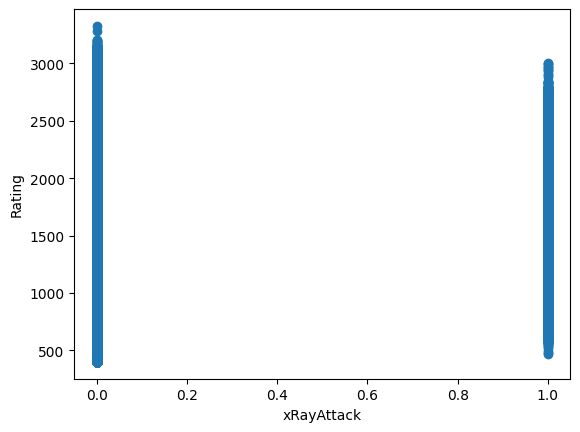

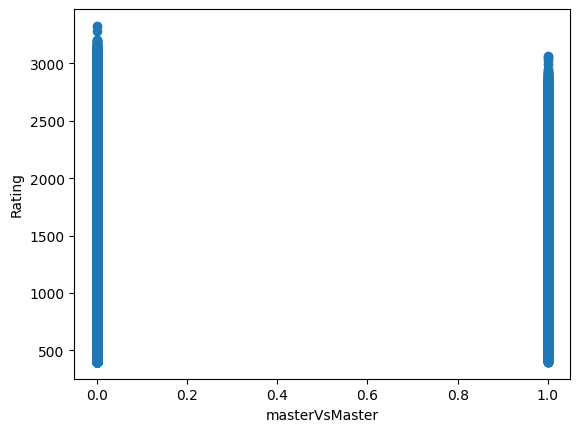

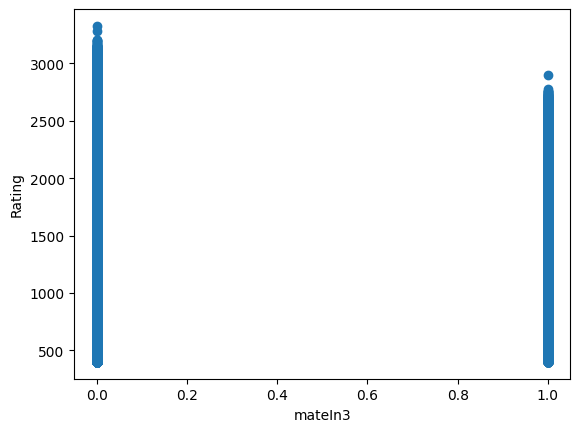

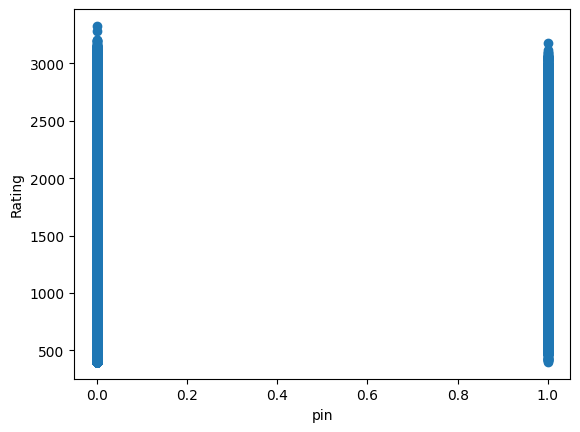

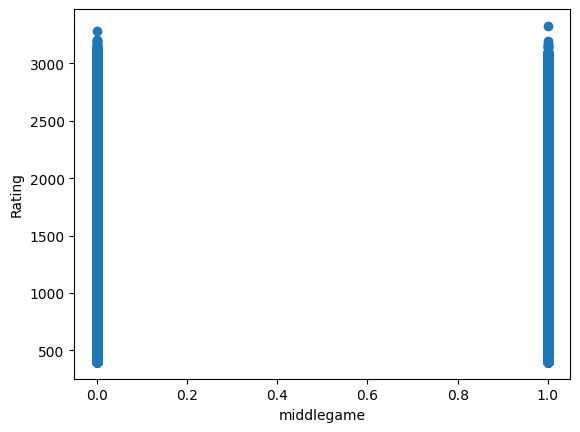

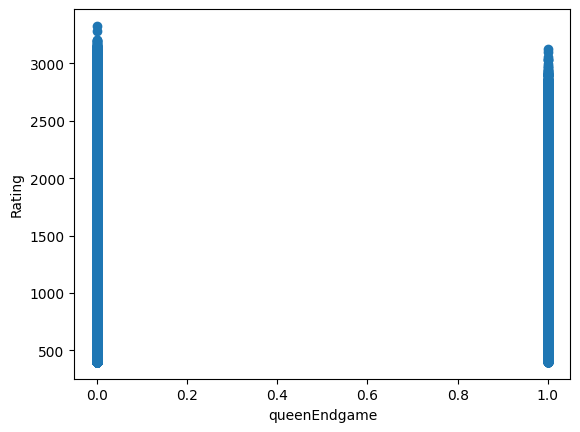

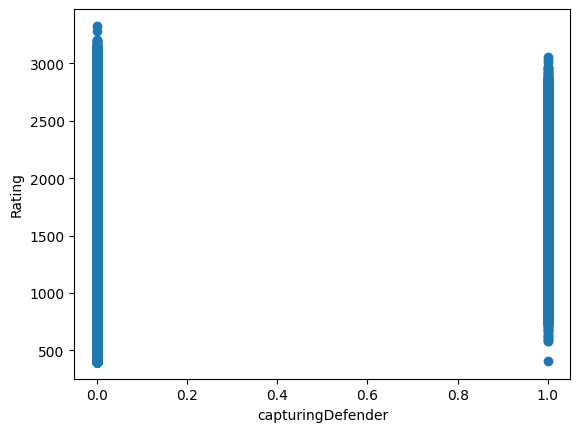

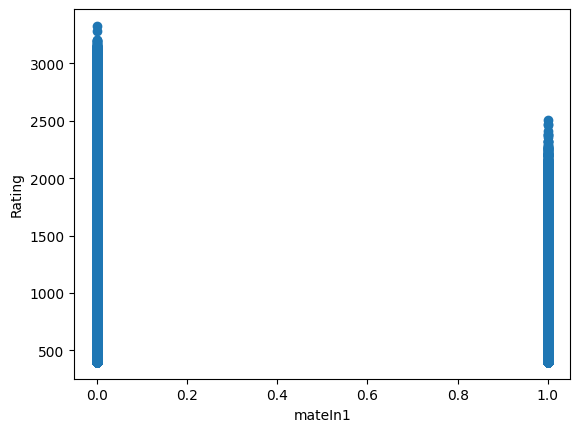

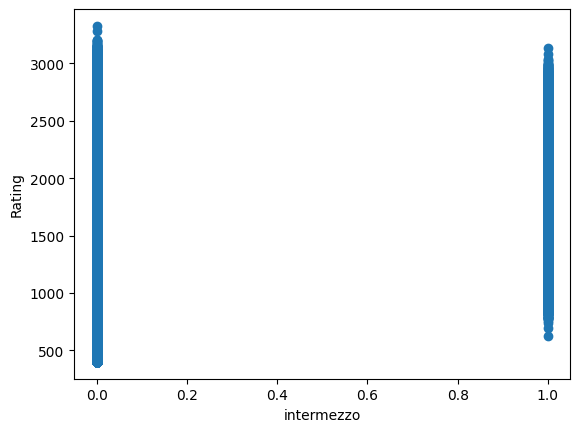

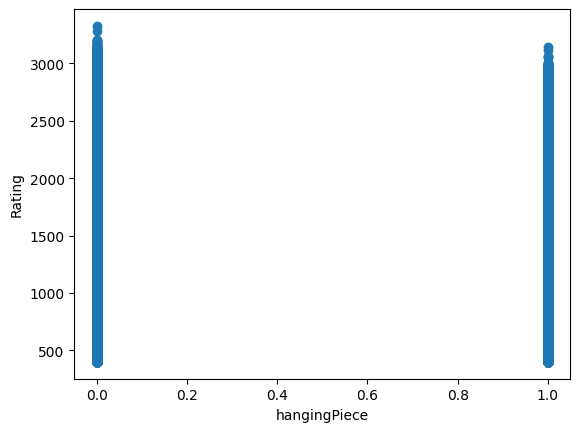

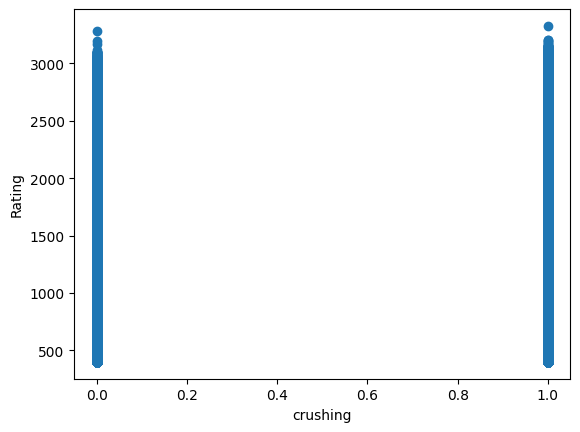

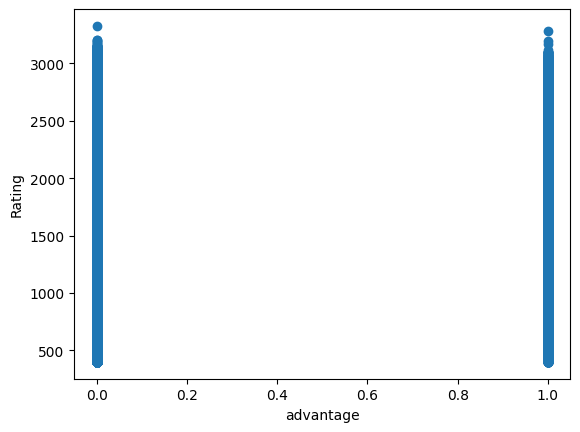

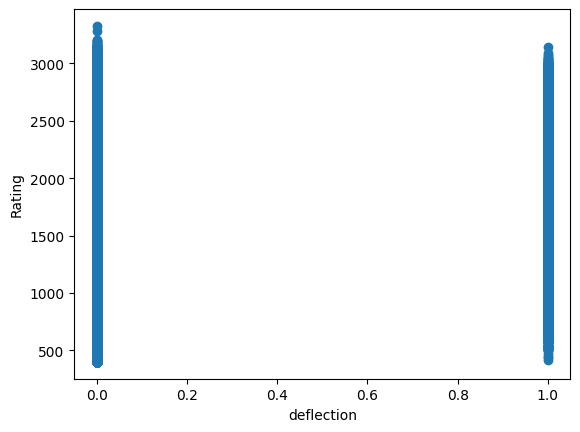

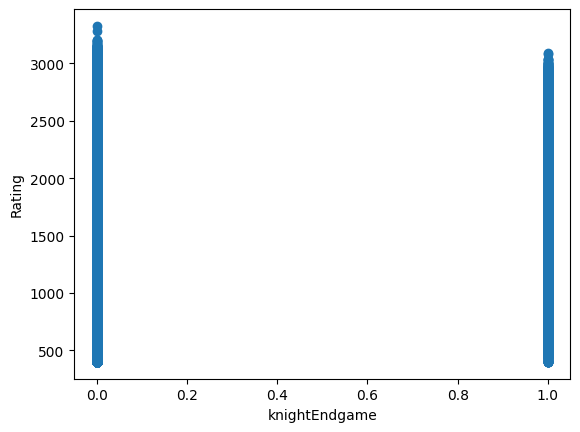

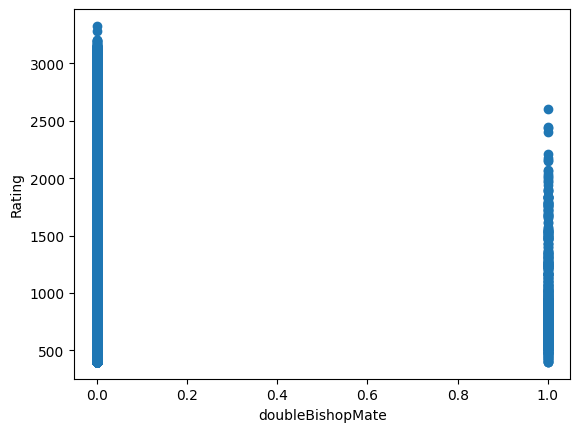

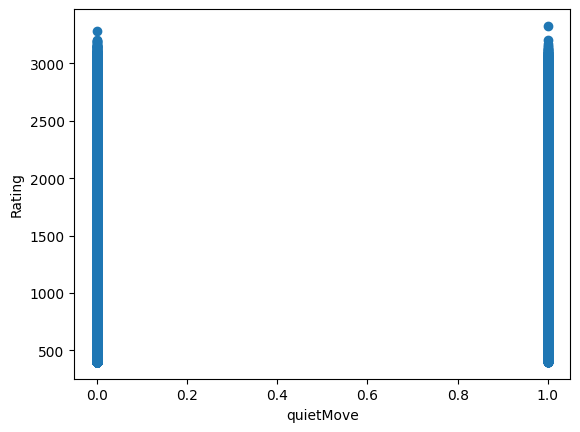

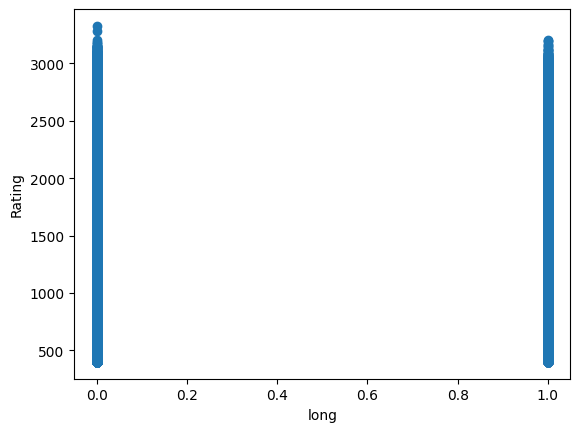

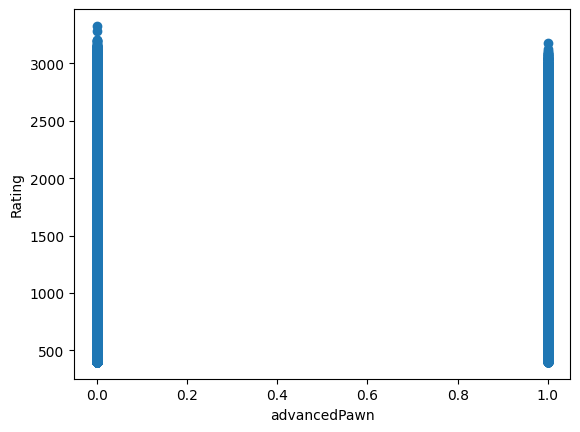

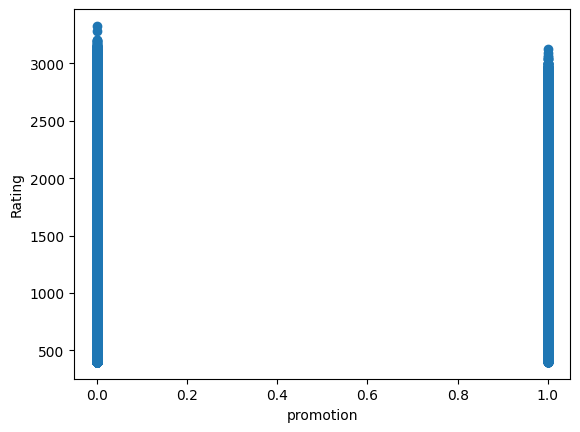

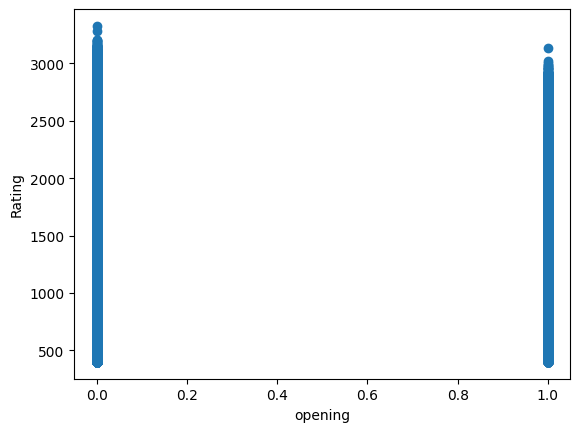

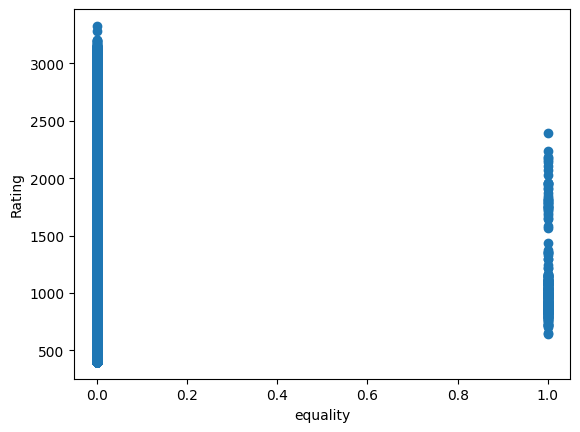

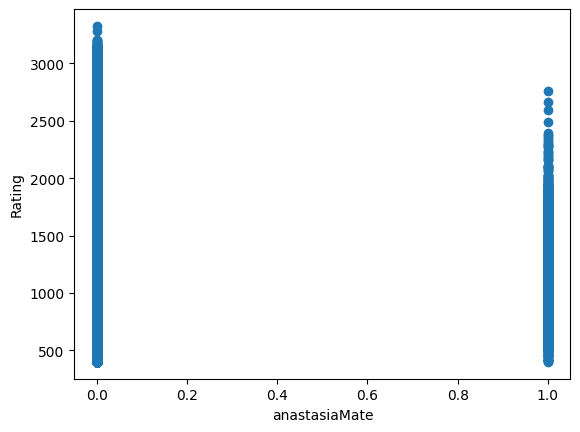

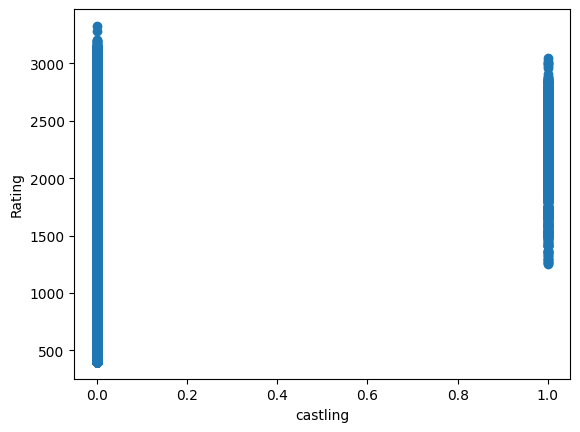

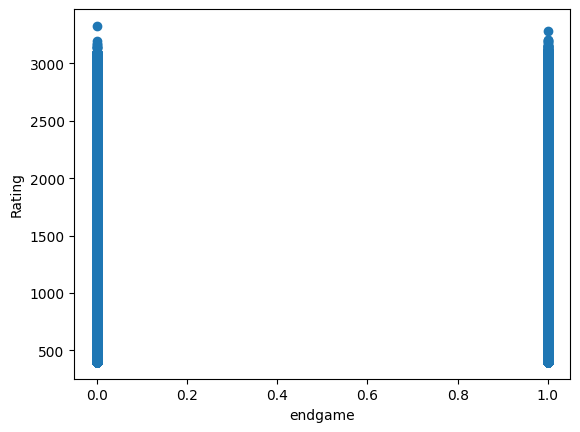

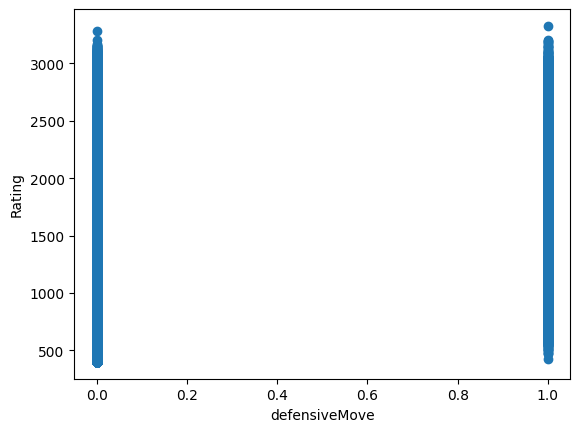

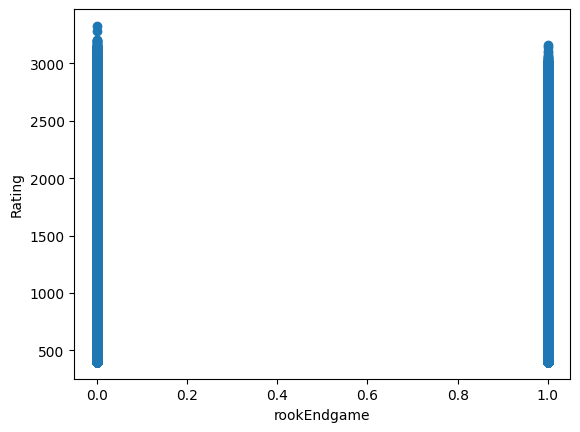

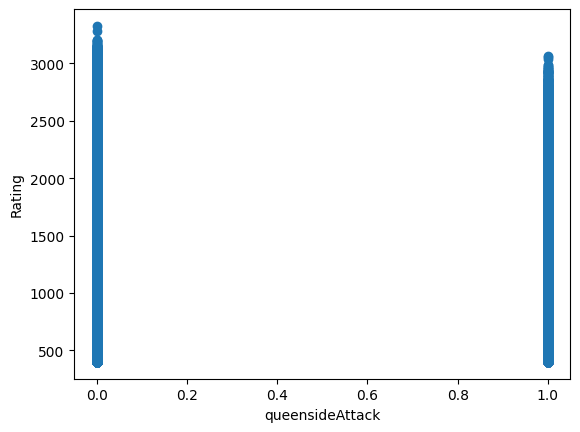

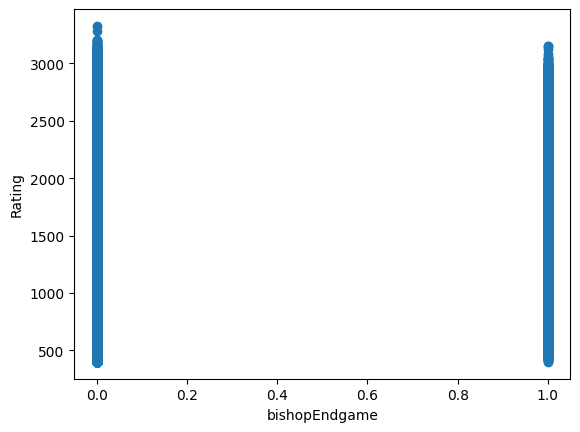

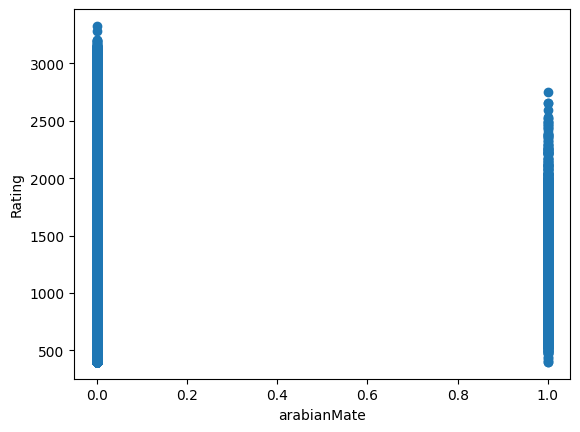

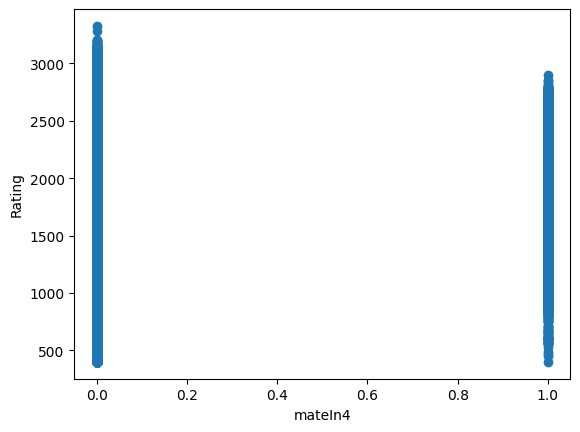

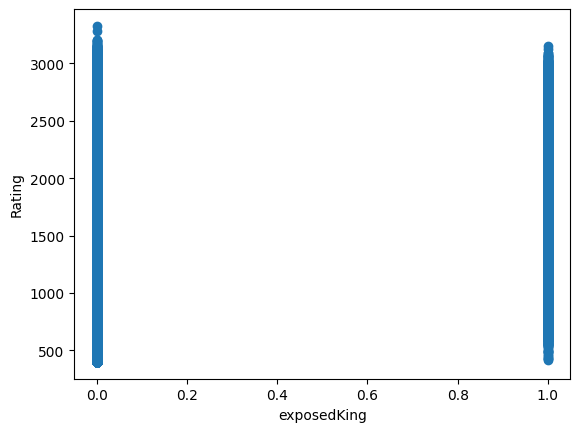

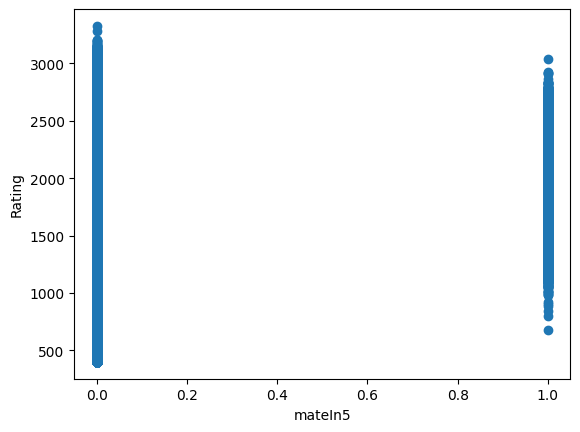

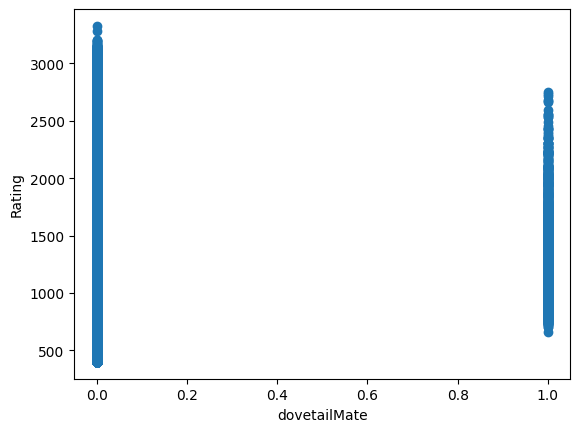

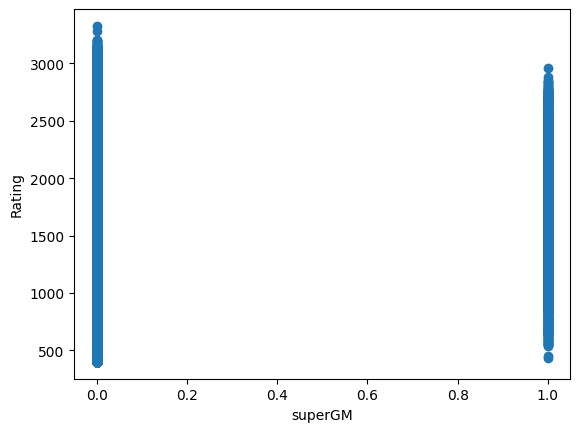

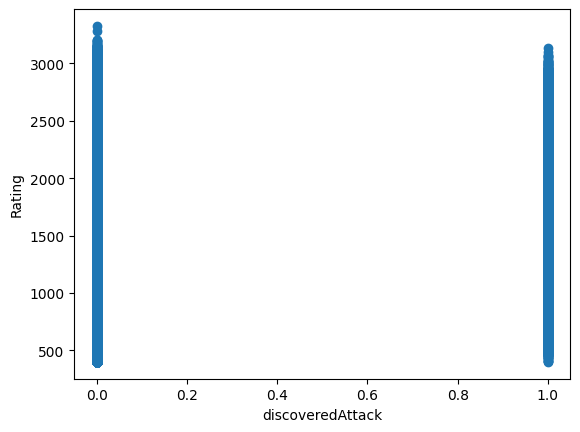

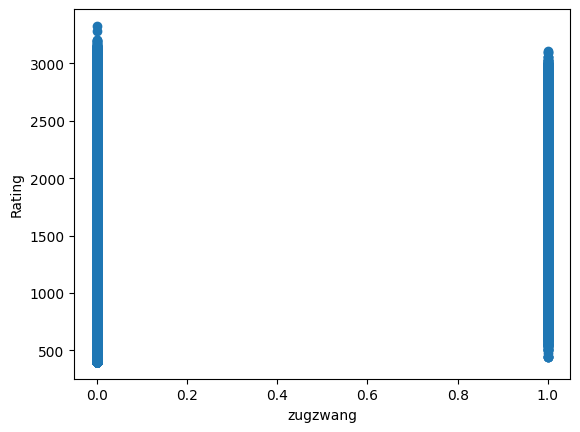

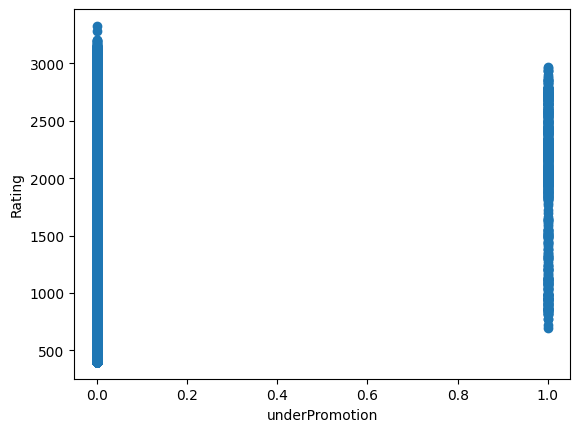

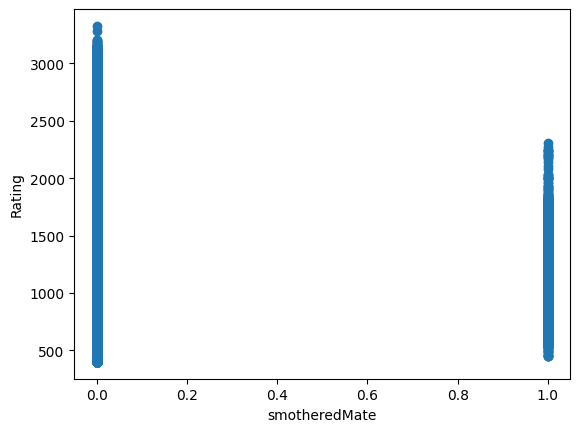

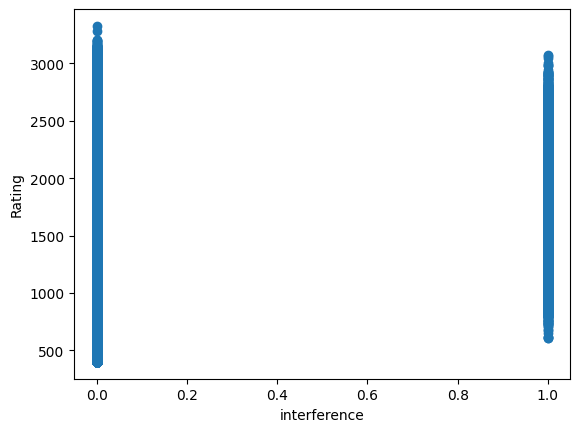

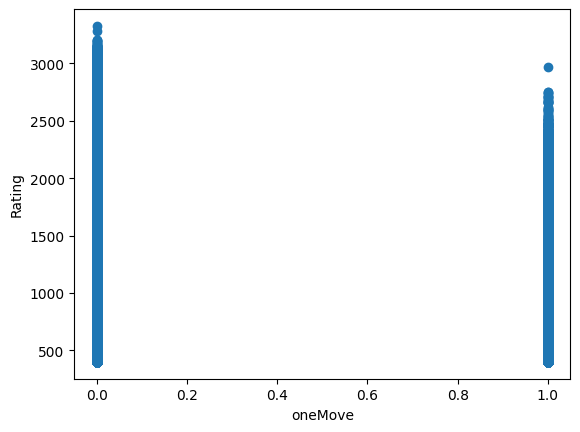

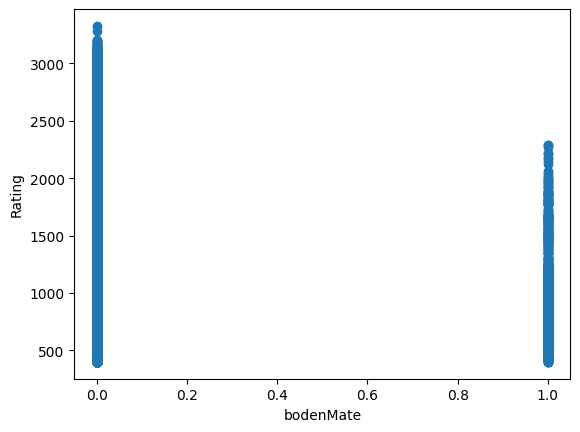

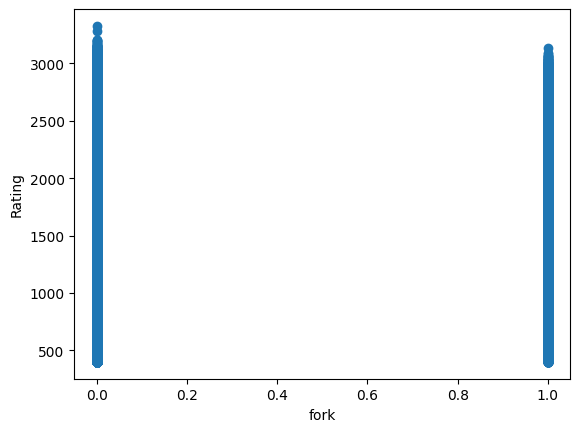

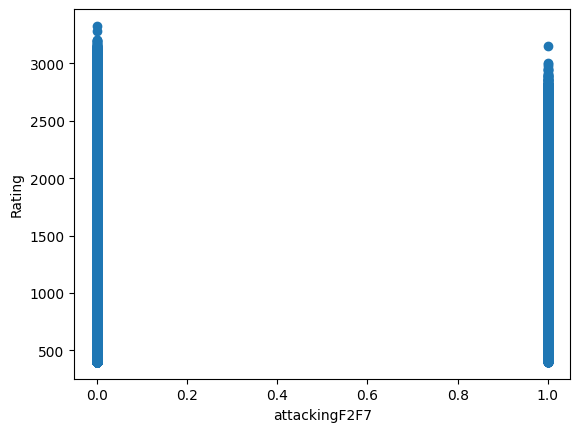

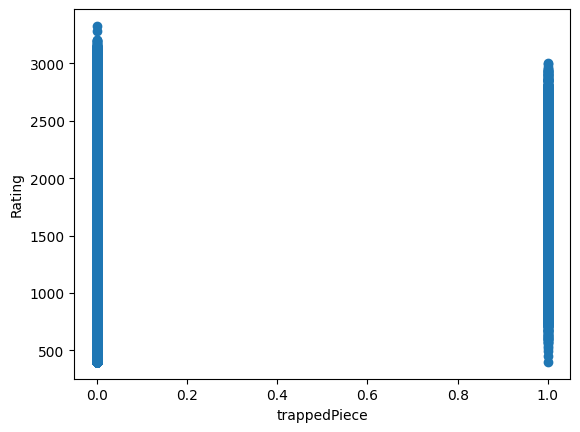

In [4]:
df.describe()

# check skew
df.skew(numeric_only=True).sort_values(key=abs, ascending=False)

# # check correlation
corr_threshold = 0.5

# calculate the correlation matrix
corr_matrix = df.corr()

# create heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, cmap="coolwarm")

plt.show()


# corr threshold
corr_threshold = 0.5

r_matrix_filtered = corr_matrix[((corr_matrix > corr_threshold) | (corr_matrix < -corr_threshold)) & (corr_matrix != 1.0)]

corr_list = corr_matrix.stack().reset_index()
corr_list.columns = ['Feature 1', 'Feature 2', 'Correlation']

# filter out the self-correlations
corr_list = corr_list[corr_list['Feature 1'] != corr_list['Feature 2']]

print(corr_list)

#plot each feature against the target
for feature in df.columns:
    plt.scatter(df[feature], y)
    plt.xlabel(feature)
    plt.ylabel("Rating")
    plt.show()

In [3]:
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
class ChessMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(len(df.columns), 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
        

    def forward(self, x):
        return self.layers(x)
    

In [93]:
X = torch.tensor(df.values).float()
y = torch.tensor(y).float()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

C:\Users\tonyt\AppData\Local\Temp\ipykernel_19032\1283857819.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()


In [6]:
from torch.utils.data import Dataset

class NumpyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

In [52]:
batch_size = 64
train_set = NumpyDataset(X_train, y_train)
validation_set = NumpyDataset(X_val, y_val)
test_set = NumpyDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [22]:
model = ChessMLP().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [23]:
def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            model.train()
            for inputs, labels in train_loader:
                inputs = inputs.cuda()
                labels = labels.cuda()
                optimizer.zero_grad()
                outputs = model.forward(inputs).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            
            with torch.no_grad():
                model.eval()
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader, mode):
    true, pred = [], []
    with torch.no_grad():
        model.eval()
        for inputs, labels  in test_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            predicted = outputs.squeeze()
            true.append(labels)
            pred.append(predicted)
    
    true = np.concatenate([t.cpu() for t in true])
    pred = np.concatenate([p.cpu() for p in pred])
    loss = mean_squared_error(true, pred) 
    print('%s MSE loss: %0.3f' % (mode, loss))
    return loss, true, pred

In [24]:
train_network(model, train_loader, val_loader, criterion, optimizer)
acc, true, pred = test_network(model, test_loader, 'Test')

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 129543.51792
   Val loss: 125187.17619

EPOCH 1
 Train loss: 123634.63747
   Val loss: 123054.54167

EPOCH 2
 Train loss: 122343.45166
   Val loss: 122499.57230

EPOCH 3
 Train loss: 121525.55216
   Val loss: 121876.82133

EPOCH 4
 Train loss: 120914.94233
   Val loss: 121262.92793

EPOCH 5
 Train loss: 120443.02934
   Val loss: 120933.70980

EPOCH 6
 Train loss: 120058.56133
   Val loss: 120567.47119

EPOCH 7
 Train loss: 119714.24609
   Val loss: 120262.47237

EPOCH 8
 Train loss: 119412.78446
   Val loss: 120037.78787

EPOCH 9
 Train loss: 119151.56222
   Val loss: 119850.31016

EPOCH 10
 Train loss: 118911.13848
   Val loss: 119724.24972

EPOCH 11
 Train loss: 118695.67095
   Val loss: 119504.94862

EPOCH 12
 Train loss: 118498.76820
   Val loss: 119358.41078

EPOCH 13
 Train loss: 118320.65880
   Val loss: 119354.63453

EPOCH 14
 Train loss: 118153.84743
   Val loss: 119278.63323

EPOCH 15
 Train loss: 118003.54732
   Val loss: 119118.50516

EPOCH 16
 Train lo

In [100]:
def plot_result(pred, true):
    plt.figure(figsize=(10, 6))
    plt.scatter(true, pred, facecolors='none', edgecolors='blue')
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=2)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('True vs Predicted')
    plt.show()

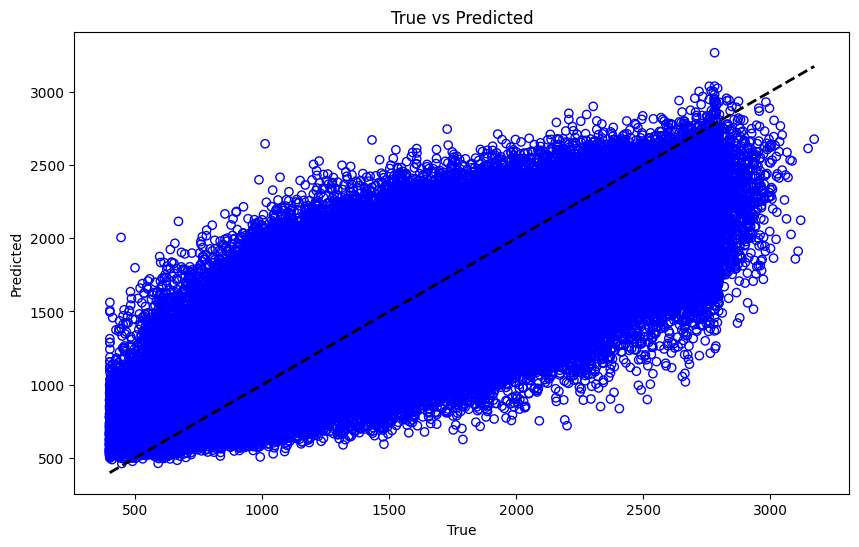

In [37]:
plot_result(pred, true)

In [ ]:
# load MLP model
model = ChessMLP()
model.load_state_dict(torch.load('NNmodel.pth'))
model.eval()


In [108]:
clf = TabNetRegressor(device_name='cuda')
try:
  clf.fit(
    X_train.numpy(), y_train.numpy().reshape(-1, 1),
    eval_set=[(X_val.numpy(), y_val.numpy().reshape(-1, 1))],
    eval_metric = ["mae"],
    loss_fn=nn.L1Loss(),
  )
except KeyboardInterrupt:
  print('Manually exiting from training early')
finally:
  preds = clf.predict(X_test.numpy()).flatten()
  print('Test MAE loss: %0.3f' % (mean_absolute_error(preds, y_test.numpy())))

c:\Users\tonyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 390.0851| val_0_mae: 285.6738586425781|  0:04:41s
epoch 1  | loss: 283.08009| val_0_mae: 278.69342041015625|  0:08:04s
epoch 2  | loss: 280.42599| val_0_mae: 277.638916015625|  0:11:46s
epoch 3  | loss: 279.33808| val_0_mae: 277.0553894042969|  0:14:31s
epoch 4  | loss: 278.36445| val_0_mae: 276.798095703125|  0:17:12s
epoch 5  | loss: 277.84814| val_0_mae: 275.0217590332031|  0:19:54s
epoch 6  | loss: 277.50655| val_0_mae: 275.3409118652344|  0:22:29s
epoch 7  | loss: 277.24588| val_0_mae: 274.37127685546875|  0:24:59s
epoch 8  | loss: 276.92155| val_0_mae: 278.644287109375|  0:27:35s
epoch 9  | loss: 276.43115| val_0_mae: 274.4028625488281|  0:30:24s
epoch 10 | loss: 276.35448| val_0_mae: 273.7074890136719|  0:33:33s
epoch 11 | loss: 276.27259| val_0_mae: 274.7747497558594|  0:47:41s
epoch 12 | loss: 276.10976| val_0_mae: 275.1769714355469|  0:49:17s
epoch 13 | loss: 275.95743| val_0_mae: 274.23687744140625|  0:50:57s
epoch 14 | loss: 275.97649| val_0_mae: 273.347900

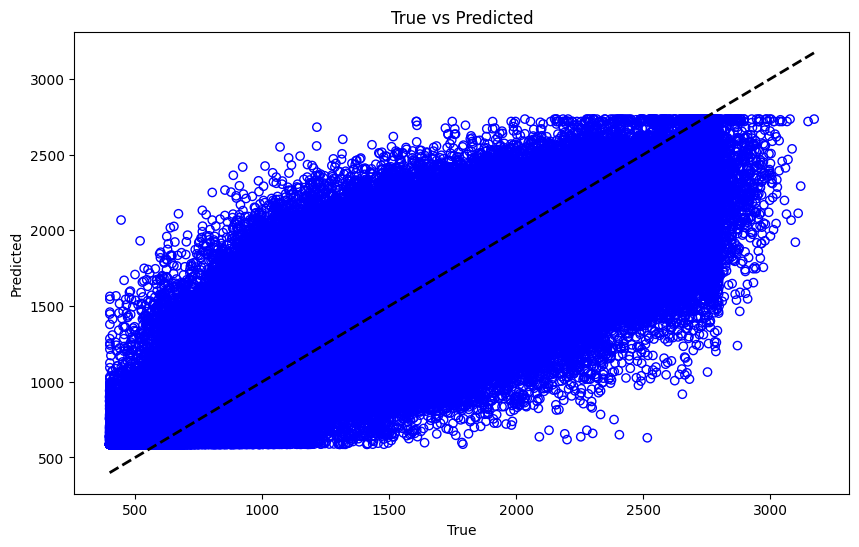

In [109]:
plot_result(preds.flatten(), y_test.numpy())